<a href="https://colab.research.google.com/github/Chaanani/Analyse_Traffic_in_France/blob/main/Analyse_Traffic_by_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # <center> Etude sur les accidents de la route en France en 2018 </h1> </center>
<center><i> Présenté par CHAANANI YOUNESS</i></center>



## 1. Introduction

Dans cette étude, J'explorerai les aspects suivants pour mieux comprendre les facteurs contribuant aux accidents de la route :

- Identification des heures de la journée où les accidents sont les plus fréquents.
- Analyse de la corrélation entre les types de routes et les conditions de conduite influençant les accidents corporels.
- Évaluation des variations des conditions d'accidents dans différentes communes.
- Détermination de la tranche d'âge la plus à risque en matière de conduite dangereuse.

Mon objectif est d'étudier les liens entre les accidents, y compris ceux ayant des conséquences fatales, en prenant en compte divers facteurs tels que :

- La catégorie de la route.
- Les conditions d'éclairage.
- Les conditions météorologiques.
- L'état de la surface des routes.

Cette analyse nous permettra de mieux comprendre les dynamiques des accidents de la route et d'identifier les facteurs de risque clés.






In [3]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# @title

!pip install pyspark
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=39e23a82324d69850fa3ad602b1e7a381c150f4857848086087744ba233ba6fe
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [5]:
# @title
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
import seaborn as sns
from IPython.core.formatters import get_real_method
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.appName("AccidentsAnalysis").getOrCreate()

# Chargement des fichiers CSV
caracteristique = spark.read.csv("/content/drive/MyDrive/caracteristiques_2018.csv",header=True, inferSchema=True)

vehicule = spark.read.csv("/content/drive/MyDrive/vehicules_2018.csv", header=True, inferSchema=True)
usager = spark.read.csv("/content/drive/MyDrive/usagers_2018.csv", header=True, inferSchema=True)
lieux = spark.read.csv("/content/drive/MyDrive/lieux_2018.csv", header=True, inferSchema=True)

In [6]:
# @title
caracteristiques = caracteristique.select(col("Num_Acc"),col("agg"),col("jour"),col("mois"),col("hrmn"),col("lum"),col("dep"), col("com"),col("atm"),col("col"),col("lat"),col("long"))
#["Num_Acc","jour ","mois","hrmn","lum","dep", "com","atm","col","lat","long"]
vehicules = vehicule.select(col("Num_Acc"), col("catv"))
#["Num_Acc", "catv"]
usagers=usager.select(col("Num_Acc"), col("sexe"), col("grav"),col("An_nais"))
#["Num_Acc","sexe","grav","An_nais"]
lieuxs = lieux.select(col("Num_Acc"), col("catr"), col("voie"), col("surf"))
#["Num_Acc","catr","voie","surf"]

In [7]:
# @title
def jointwithdatasets(df1, df2,df3, df4):
  return df1.join(df2, "Num_Acc", "inner").join(df3, "Num_Acc", "inner").join(df4, "Num_Acc", "inner")
data = jointwithdatasets(caracteristiques, lieuxs, usagers, vehicules ).dropDuplicates(['Num_Acc'])

In [8]:
# @title

# Renommerles colonnes
def renameColumn(data):
      data = (data.withColumnRenamed("lum", "Conditions_lumière")
                   .withColumnRenamed("grav", "Gravité_accident")
                   .withColumnRenamed("atm", "Atmosphere")
                   .withColumnRenamed("com", "Commune")
                   .withColumnRenamed("int", "Intersections")
                   .withColumnRenamed("col", "Collision")
                   .withColumnRenamed("surf", "Conditions_Surface")
                   .withColumnRenamed("lat", "Latitude")
                   .withColumnRenamed("long", "Longitude")
                   .withColumnRenamed("agg", "Agglomération")
                   .withColumnRenamed("catr", "Catégorie_Route")
                   .withColumnRenamed("dep", "Département")
                   .withColumnRenamed("An_nais", "AnnéeNessaince")
                   .withColumnRenamed("catv", "Catégorie_vehicule"))
      return data

data= renameColumn(data)


In [9]:
# @title
#Calcul des valeurs manquantes pour chaque colonne
def compteValeurmanquent(data):
    null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])
    null_counts.show()
compteValeurmanquent(data)

+-------+-------------+----+----+----+------------------+-----------+-------+----------+---------+--------+---------+---------------+-----+------------------+----+----------------+--------------+------------------+
|Num_Acc|Agglomération|jour|mois|hrmn|Conditions_lumière|Département|Commune|Atmosphere|Collision|Latitude|Longitude|Catégorie_Route| voie|Conditions_Surface|sexe|Gravité_accident|AnnéeNessaince|Catégorie_vehicule|
+-------+-------------+----+----+----+------------------+-----------+-------+----------+---------+--------+---------+---------------+-----+------------------+----+----------------+--------------+------------------+
|      0|            0|   0|   0|   0|                 0|          6|      0|         5|        2|    1825|     1827|              0|21893|               442|   0|               0|             8|                 0|
+-------+-------------+----+----+----+------------------+-----------+-------+----------+---------+--------+---------+---------------+-----+-

In [10]:
# @title

# Calcul de la mode pour chaque colonne
mode_conditions_surface = data.groupBy("Conditions_Surface").count().orderBy("count", ascending=False).first()["Conditions_Surface"]
mode_atmosphere = data.groupBy("Atmosphere").count().orderBy("count", ascending=False).first()["Atmosphere"]



In [11]:
# @title
# Remplacer les valeurs nulles par la mode
env_data = data.withColumn("Conditions_Surface", when(col("Conditions_Surface").isNull(), mode_conditions_surface).otherwise(col("Conditions_Surface")))
data = data.withColumn("Atmosphere", when(col("Atmosphere").isNull(), mode_atmosphere).otherwise(col("Atmosphere")))

In [12]:
# @title
# Remplacement des valeurs pour "Gravité_accident"
data = data.withColumn("Gravité_accident",
    F.when(F.col("Gravité_accident") == 1, "indemne")
    .when(F.col("Gravité_accident") == 2, "tué")
    .when(F.col("Gravité_accident") == 3, "blessé hospitalisé")
    .otherwise("blessé léger"))

# Remplacement des valeurs pour "Conditions_lumière"
data = data.withColumn("Conditions_lumière",
    F.when(F.col("Conditions_lumière") == 1, "Plein jour")
    .when(F.col("Conditions_lumière") == 2, "Crépuscule ou aube")
    .when(F.col("Conditions_lumière") == 3, "Nuit sans éclairage public")
    .when(F.col("Conditions_lumière") == 4, "Nuit avec éclairage public non allumé")
    .otherwise("Nuit avec éclairage public allumé"))


# Remplacement des valeurs pour "Atmosphere"
data = data.withColumn("Atmosphere",
    F.when(F.col("Atmosphere") == 1, "Normale")
    .when(F.col("Atmosphere") == 2, "Pluie légère")
    .when(F.col("Atmosphere") == 3, "Pluie forte")
    .when(F.col("Atmosphere") == 4, "Neige ou gèle")
    .when(F.col("Atmosphere") == 5, "Brouillard ou fumée")
    .when(F.col("Atmosphere") == 6, "Vent fort ou tempête")
    .when(F.col("Atmosphere") == 7, "Temps éblouissant")
    .when(F.col("Atmosphere") == 8, "Temps couvert")
    .otherwise("Autre"))

# Remplacement des valeurs pour "Catégorie_Route"
data = data.withColumn("Catégorie_Route",
    F.when(F.col("Catégorie_Route") == 1, "Autoroute")
    .when(F.col("Catégorie_Route") == 2, "Route Nationale")
    .when(F.col("Catégorie_Route") == 3, "Route Départementale")
    .when(F.col("Catégorie_Route") == 4, "Voie Communale")
    .when(F.col("Catégorie_Route") == 5, "Hors réseau public")
    .when(F.col("Catégorie_Route") == 6, "Parc, Stationnement ou autre Voie de Circulation Publique")
    .otherwise("Autre"))

# Remplacement des valeurs pour "Conditions_Surface"
data = data.withColumn("Conditions_Surface",
    F.when(F.col("Conditions_Surface") == 1, "Normale")
    .when(F.col("Conditions_Surface") == 2, "Mouillée")
    .when(F.col("Conditions_Surface") == 3, "Flaques")
    .when(F.col("Conditions_Surface") == 4, "Inondée")
    .when(F.col("Conditions_Surface") == 5, "Enneigée")
    .when(F.col("Conditions_Surface") == 6, "Boue")
    .when(F.col("Conditions_Surface") == 7, "Verglacée")
    .when(F.col("Conditions_Surface") == 8, "Corps gras - huile")
    .otherwise("Autre"))


In [13]:
# @title
# Création de deux colonnes Tués et blessés hospitalisés en fonction de leur gravité
data_gravit = data.select(
    col('Num_Acc'),
    F.when(data['Gravité_accident'] == "tué" , 1).otherwise(0).alias('Tué'),
    F.when(data['Gravité_accident'] == 'blessé hospitalisé', 1).otherwise(0).alias('blessé hospitalisé')
)

In [14]:
# @title
# la jointure entre les données que j'ai créées et les données
data_df = data_gravit.join(data, on='Num_Acc' )
Acc_df= data_df.withColumn('Nombre_Accident', F.lit(1))

Ces graphiques illustrent la tendance mensuelle des accidents de la route. Il est observé que les distributions des accidents sont similaires d'un mois à l'autre, ce qui suggère une absence de variations saisonnières significatives ou de tendances particulières liées à des périodes spécifiques de l'année. En conséquence, il est difficile de tirer des conclusions définitives ou d'identifier des motifs clairs en lien avec les fluctuations mensuelles des accidents.

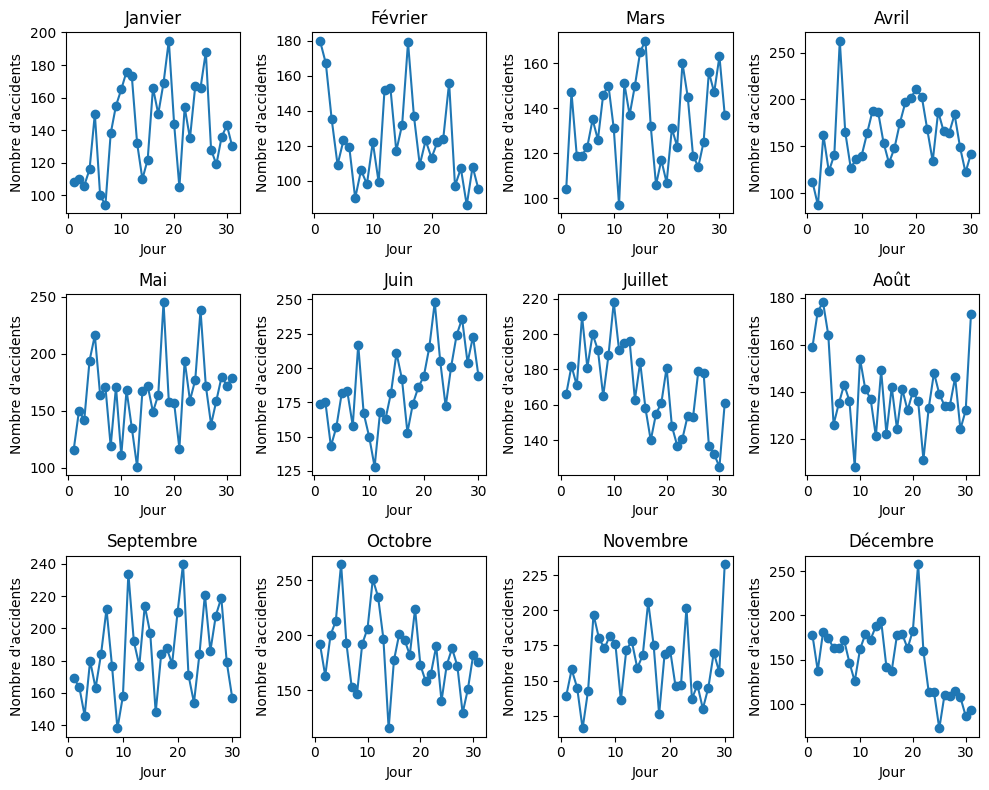

In [16]:
import matplotlib.pyplot as plt
from IPython.display import Markdown
display(Markdown("""Ces graphiques illustrent la tendance mensuelle des accidents de la route. Il est observé que les distributions des accidents sont similaires d'un mois à l'autre, ce qui suggère une absence de variations saisonnières significatives ou de tendances particulières liées à des périodes spécifiques de l'année. En conséquence, il est difficile de tirer des conclusions définitives ou d'identifier des motifs clairs en lien avec les fluctuations mensuelles des accidents."""))
def traitement(df):
    liste = []
    for i in range(1, 13):
        liste.append(df.filter(df.mois == i).groupby("jour").agg(sum("Nombre_Accident").alias("somme_Accident_bymois")).toPandas().sort_values(by='jour', ascending=True))

    # Définir les titres des mois
    mois = ["Janvier", "Février", "Mars", "Avril", "Mai", "Juin", "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"]

    # Créer une figure avec subplots
    fig, axs = plt.subplots(3, 4, figsize=(10, 8))  # 3 lignes, 4 colonnes
    axs = axs.flatten()  # Transformer en tableau 1D pour un accès facile

    # Boucle pour créer un graphique pour chaque mois
    for k in range(12):
        ax = axs[k]
        ax.plot(liste[k].jour, liste[k].somme_Accident_bymois, marker='o', linestyle='-')
        ax.set_title(mois[k])
        ax.set_xlabel("Jour")
        ax.set_ylabel("Nombre d'accidents")

    # Ajuster l'espace entre les graphiques
    plt.tight_layout()

    # Afficher la figure
    plt.show()

    return liste

# Utilisation de la fonction avec votre DataFrame
datatraitement = traitement(Acc_df)


In [17]:
# @title
Acc_aff = Acc_df.withColumn("hrmn", expr("substring(hrmn, 1, length(hrmn) - 2)"))

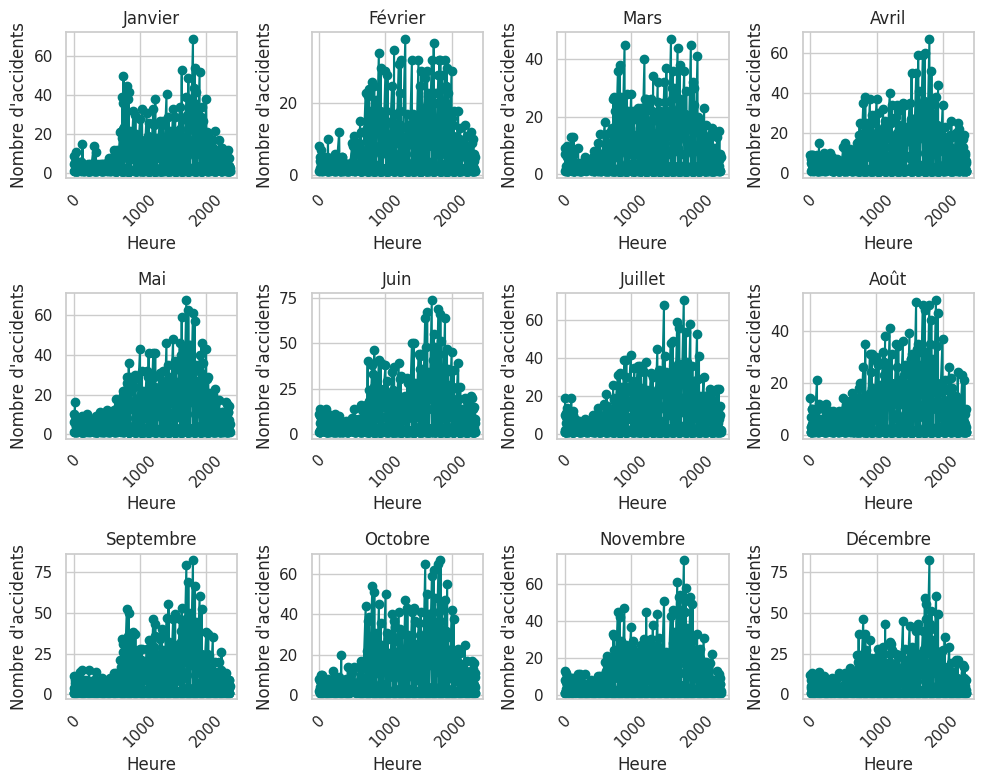

Ces graphiques illustrent la fréquence des accidents de la route selon l'heure et le mois. Il est notable que la majorité des accidents se produisent entre 14h et 20h. Cette période coïncide généralement avec l'heure de pointe en fin de journée, où le volume de trafic est élevé en raison des déplacements domicile-travail.

+ Améliorer la gestion du trafic pendant les heures de pointe, par exemple en ajustant les feux de circulation pour optimiser le flux de véhicules.
+ Encourager le covoiturage ou l'utilisation des transports en commun pour réduire le nombre de véhicules sur les routes.
+ Augmenter la présence policière sur les routes durant ces heures pour dissuader les comportements de conduite dangereux.
+ Installer des panneaux d'avertissement dynamiques qui alertent les conducteurs en temps réel sur les conditions de trafic et les dangers potentiels.

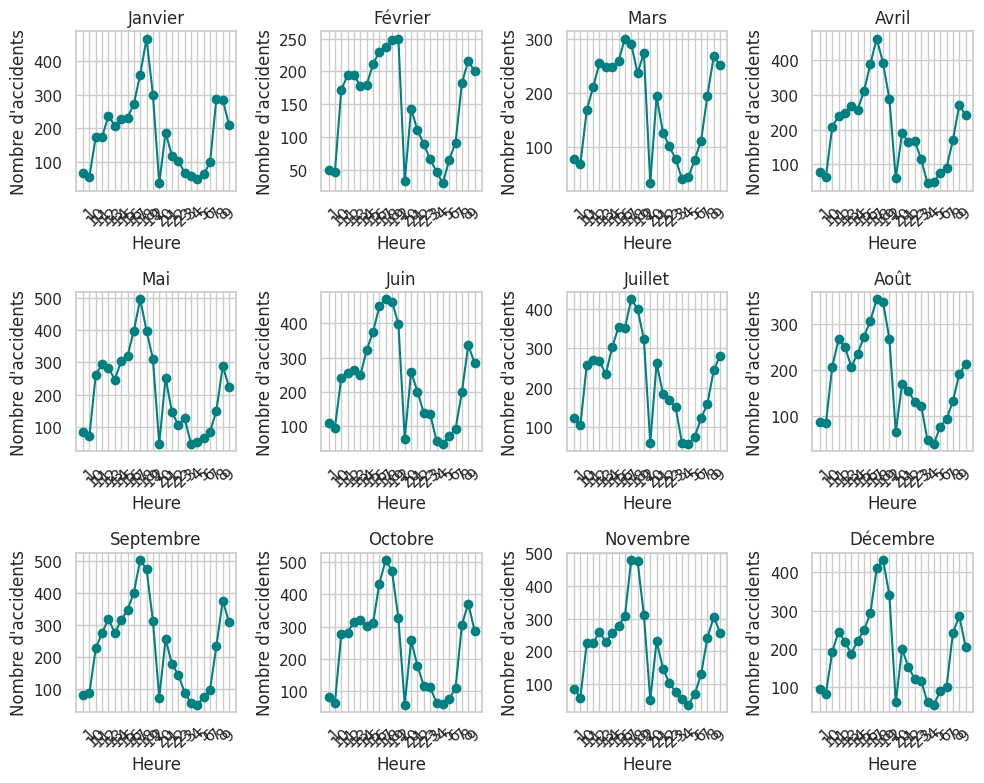

In [20]:
#import matplotlib.pyplot as plt
import seaborn as sns  # Pour le style

def traitementbyheure(df):
    liste = []
    for i in range(1, 13):
        liste.append(df.filter(df.mois == i).groupby("hrmn").agg(sum("Nombre_Accident").alias("somme_Accident_bymois")).toPandas().sort_values(by='hrmn', ascending=True))

    # Définir les titres des mois
    mois = ["Janvier", "Février", "Mars", "Avril", "Mai", "Juin", "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"]

    # Créer une figure avec subplots
    fig, axs = plt.subplots(3, 4, figsize=(10, 8))  # 3 lignes, 4 colonnes
    axs = axs.flatten()  # Transformer en tableau 1D pour un accès facile

    # Appliquer un style avec seaborn
    sns.set(style="whitegrid")

    # Boucle pour créer un graphique pour chaque mois
    for k in range(12):
        ax = axs[k]
        ax.plot(liste[k].hrmn, liste[k].somme_Accident_bymois, marker='o', linestyle='-', color='teal')
        ax.set_title(mois[k])
        ax.set_xlabel("Heure")
        ax.set_ylabel("Nombre d'accidents")
        ax.tick_params(axis='x', rotation=45)  # Rotation des étiquettes de l'axe x

    # Ajuster l'espace entre les graphiques et améliorer la lisibilité
    plt.tight_layout()

    # Afficher la figure
    plt.show()

    return liste

# Utilisation de la fonction avec votre DataFrame
datatraitementbyheure = traitementbyheure(Acc_df)

display(Markdown("Ces graphiques illustrent la fréquence des accidents de la route selon l'heure et le mois. Il est notable que la majorité des accidents se produisent entre 14h et 20h. Cette période coïncide généralement avec l'heure de pointe en fin de journée, où le volume de trafic est élevé en raison des déplacements domicile-travail."))
display(Markdown("""+ Améliorer la gestion du trafic pendant les heures de pointe, par exemple en ajustant les feux de circulation pour optimiser le flux de véhicules.
+ Encourager le covoiturage ou l'utilisation des transports en commun pour réduire le nombre de véhicules sur les routes.
+ Augmenter la présence policière sur les routes durant ces heures pour dissuader les comportements de conduite dangereux.
+ Installer des panneaux d'avertissement dynamiques qui alertent les conducteurs en temps réel sur les conditions de trafic et les dangers potentiels."""))
datatraitement= traitementbyheure(Acc_aff)

In [19]:
# @title
# Cette script calcule le nombre d'accidents pour chaque type de route.
byRoadType = Acc_df.groupBy('Catégorie_Route').sum("Nombre_Accident", "blessé hospitalisé", "Tué")
# Renommer les colonnes après l'agrégation pour éliminer le préfixe 'sum(' et le suffixe ')'.
byRoadType = byRoadType.withColumnRenamed('sum(Nombre_Accident)', 'Nombre_Accident')\
                       .withColumnRenamed('sum(blessé hospitalisé)', 'blessé hospitalisé')\
                       .withColumnRenamed('sum(Tué)', 'Tué')

byRoadType.show(200)

+--------------------+---------------+------------------+----+
|     Catégorie_Route|Nombre_Accident|blessé hospitalisé| Tué|
+--------------------+---------------+------------------+----+
|     Route Nationale|           3857|               785| 163|
|Parc, Stationneme...|            423|               134|  14|
|      Voie Communale|          26728|              4892| 459|
|           Autoroute|           5572|               641| 126|
|  Hors réseau public|            100|                37|   6|
|Route Départementale|          20087|              6566|1274|
|               Autre|           1016|               295|  30|
+--------------------+---------------+------------------+----+



Ce graphique fournit une analyse détaillée de la fréquence des accidents de la route, des personnes blessées nécessitant une hospitalisation, et des décès, en fonction du type de route. Il ressort clairement que les voies communales et les routes départementales enregistrent un nombre élevé d'accidents et de blessures par rapport aux autres types de routes. Cette tendance pourrait être due à plusieurs facteurs, tels que le volume de trafic élevé, les limitations de vitesse moins strictes, ou un entretien routier moins rigoureux sur ces types de routes:


+ Renforcer l'entretien des routes, en particulier dans les zones à haut risque.
+ Installer des signalisations routières plus claires et des systèmes d'éclairage améliorés pour augmenter la visibilité.
+ Imposer des limitations de vitesse plus strictes sur les routes départementales et communales.
+ Installer des radars automatiques pour dissuader les excès de vitesse.

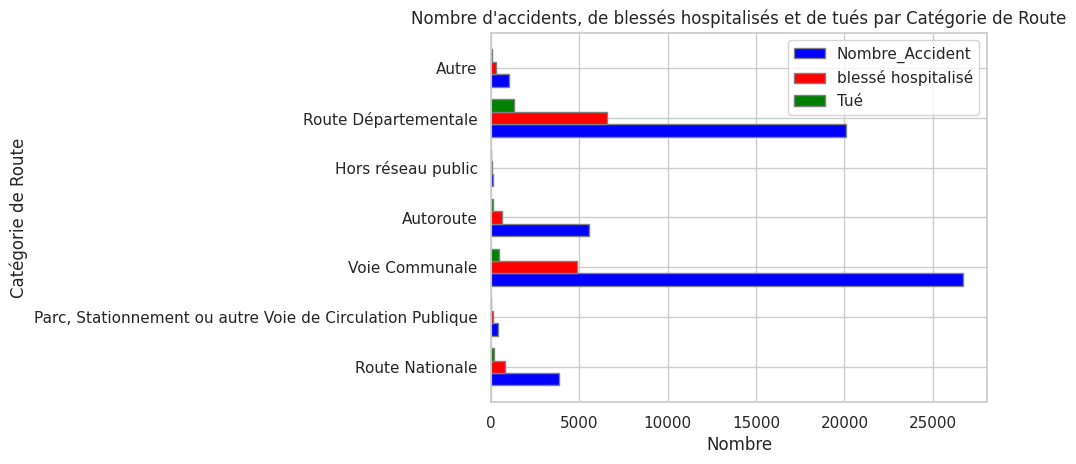

In [21]:
# @title
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
display(Markdown("Ce graphique fournit une analyse détaillée de la fréquence des accidents de la route, des personnes blessées nécessitant une hospitalisation, et des décès, en fonction du type de route. Il ressort clairement que les voies communales et les routes départementales enregistrent un nombre élevé d'accidents et de blessures par rapport aux autres types de routes. Cette tendance pourrait être due à plusieurs facteurs, tels que le volume de trafic élevé, les limitations de vitesse moins strictes, ou un entretien routier moins rigoureux sur ces types de routes:"))
display(Markdown("""
+ Renforcer l'entretien des routes, en particulier dans les zones à haut risque.
+ Installer des signalisations routières plus claires et des systèmes d'éclairage améliorés pour augmenter la visibilité.
+ Imposer des limitations de vitesse plus strictes sur les routes départementales et communales.
+ Installer des radars automatiques pour dissuader les excès de vitesse."""))

RoadbyCat = byRoadType.toPandas()

# Définir les catégories et les données
categories = RoadbyCat['Catégorie_Route']
n_categories = len(categories)
accidents = RoadbyCat['Nombre_Accident']
hospitalises = RoadbyCat['blessé hospitalisé']
tues = RoadbyCat['Tué']

# Création des positions des barres sur l'axe Y
barWidth = 0.25  # Largeur des barres
y_pos = np.arange(n_categories)
y_pos_b = [x + barWidth for x in y_pos]
y_pos_c = [x + barWidth for x in y_pos_b]

# Créer les barres horizontales pour chaque catégorie
plt.barh(y_pos, accidents, color='blue', height=barWidth, edgecolor='grey', label='Nombre_Accident')
plt.barh(y_pos_b, hospitalises, color='red', height=barWidth, edgecolor='grey', label='blessé hospitalisé')
plt.barh(y_pos_c, tues, color='green', height=barWidth, edgecolor='grey', label='Tué')

# Ajouter des légendes et des titres
plt.xlabel('Nombre')
plt.ylabel('Catégorie de Route')
plt.title('Nombre d\'accidents, de blessés hospitalisés et de tués par Catégorie de Route')
plt.yticks([r + barWidth for r in range(n_categories)], categories)
plt.legend()

# Afficher le graphique
plt.show()



Cette carte illustre la répartition géographique des accidents par département en France. Elle met en évidence un constat notable : la région parisienne enregistre un nombre d'accidents significativement plus élevé par rapport aux autres départements. Cette concentration d'accidents dans la région parisienne peut être attribuée à plusieurs facteurs.

+ La densité de population et le volume de trafic y sont nettement supérieurs, augmentant ainsi les probabilités de collisions et d'incidents.
+ la complexité du réseau routier et la fréquence élevée des changements de direction contribuent également à cette tendance.
+ a présence de nombreux points d'intérêt et de zones d'activité économique majeures dans la région parisienne intensifie le flux de véhicules, accentuant d'autant plus les risques d'accidents.

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


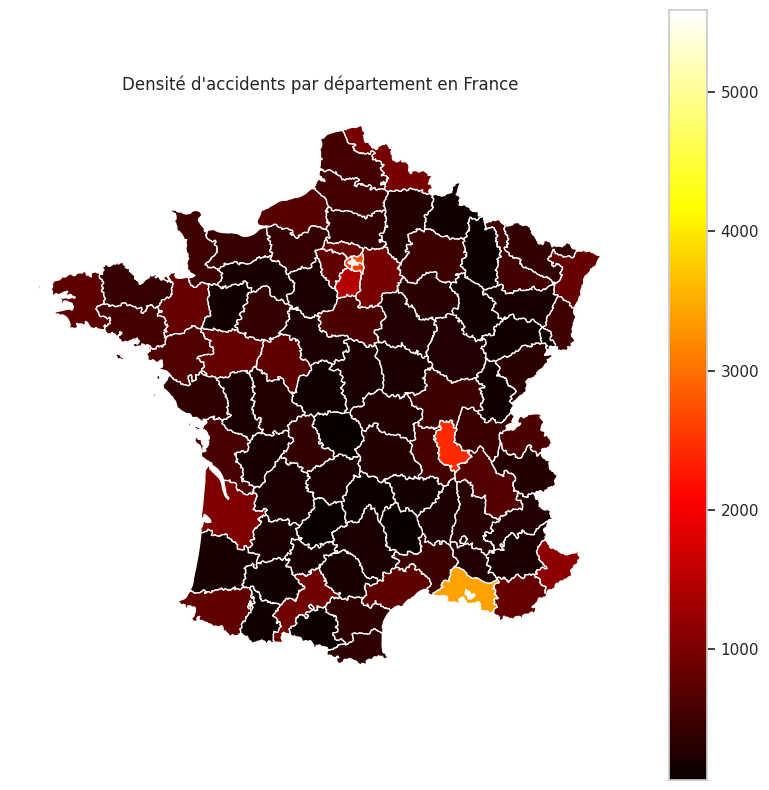

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import pandas as pd

def plotcartefrance_matplotlib(df):
    """
    Cette méthode permet de dresser une carte de température de la France, montrant la densité d'accidents dans chaque département.
    """
    # Chargement des données géospatiales
    commune_france = gpd.read_file("/content/drive/MyDrive/departements-version-simplifiee.geojson")

    # Préparation des données
    df = df.select(col("Département")/10, col("Nombre_Accident"))
    df = df.withColumn("dep", df["(Département / 10)"].cast(IntegerType())).select(col("dep"), col("Nombre_Accident"))
    df = df.groupBy("dep").agg(sum("Nombre_Accident").alias("somme_Accident_bydep"))
    df = df.toPandas()

    # Filtre et conversion des codes départementaux
    condition = (~commune_france['code'].isin(['2A', '2B', 'Ain']))  # Modifier selon besoin
    commune_france_filtered = commune_france[condition]
    commune_france_filtered['code'] = commune_france_filtered['code'].astype(int)

    # Fusionner les DataFrames
    jf = commune_france_filtered.merge(df, left_on='code', right_on='dep')

    # Créer la carte choroplèthe
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    jf.plot(column='somme_Accident_bydep', ax=ax, legend=True, cmap='hot')

    # Mise à jour de la mise en page
    ax.set_title('Densité d\'accidents par département en France')
    ax.set_axis_off()  # Désactiver l'affichage des axes

    # Afficher la figure
    plt.show()
    return jf



display(Markdown("Cette carte illustre la répartition géographique des accidents par département en France. Elle met en évidence un constat notable : la région parisienne enregistre un nombre d'accidents significativement plus élevé par rapport aux autres départements. Cette concentration d'accidents dans la région parisienne peut être attribuée à plusieurs facteurs."))
display(Markdown("""+ La densité de population et le volume de trafic y sont nettement supérieurs, augmentant ainsi les probabilités de collisions et d'incidents.
+ la complexité du réseau routier et la fréquence élevée des changements de direction contribuent également à cette tendance.
+ a présence de nombreux points d'intérêt et de zones d'activité économique majeures dans la région parisienne intensifie le flux de véhicules, accentuant d'autant plus les risques d'accidents."""))

databydep = plotcartefrance_matplotlib(Acc_df)



Ce phénomène met en lumière l'importance de renforcer les mesures de sécurité routière et d'améliorer l'infrastructure dans les zones à forte densité de trafic pour réduire le nombre d'accidents.

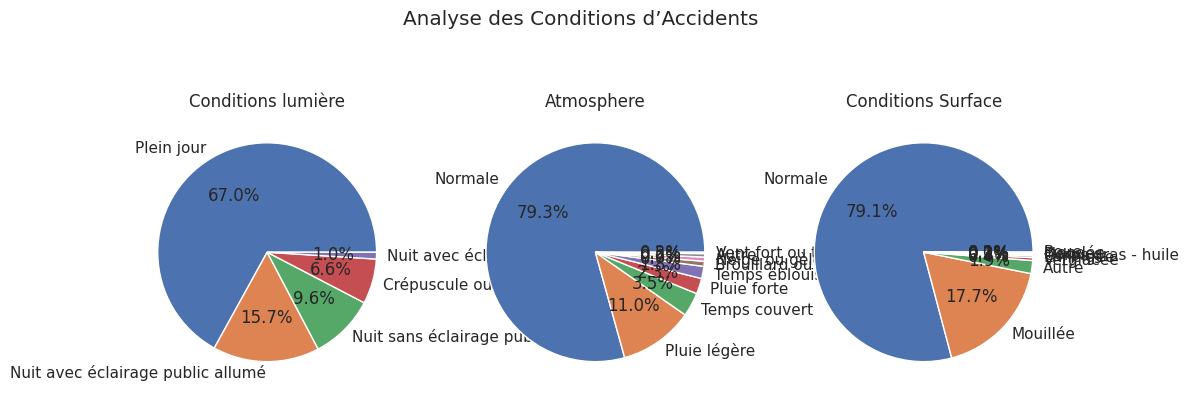

+ L'analyse des accidents révèle une distribution cohérente à travers différentes conditions environnementales en France. Une catégorie prédominante, correspondant à 70-85% des accidents, illustre probablement les jours clairs et secs, typiques du climat français. Une deuxième catégorie, couvrant 10-25% des incidents, est vraisemblablement associée à des jours pluvieux. Les conditions plus rares comptent pour le reste. Cette répartition reflète le climat et les habitudes de circulation en France, soulignant l'influence des conditions météorologiques et de la densité du trafic sur la sécurité routière.

In [26]:
import matplotlib.pyplot as plt

def plotbyCon(df):
    # Filtrer les données
    dataacc = df.filter(
        (F.col('Conditions_lumière') != 'Data missing or out of range') &
        (F.col('Atmosphere') != 'Data missing or out of range') &
        (F.col('Atmosphere') != 'Unknown') &
        (F.col('Conditions_Surface') != 'Data missing or out of range'))
    df_final = dataacc.toPandas()

    # Créer une figure avec 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))  # 1 ligne, 3 colonnes

    # Diagramme pour Conditions lumière
    axs[0].pie(df_final['Conditions_lumière'].value_counts(), labels=df_final['Conditions_lumière'].value_counts().index, autopct='%1.1f%%')
    axs[0].set_title('Conditions lumière')

    # Diagramme pour Atmosphere
    axs[1].pie(df_final['Atmosphere'].value_counts(), labels=df_final['Atmosphere'].value_counts().index, autopct='%1.1f%%')
    axs[1].set_title('Atmosphere')

    # Diagramme pour Conditions Surface
    axs[2].pie(df_final['Conditions_Surface'].value_counts(), labels=df_final['Conditions_Surface'].value_counts().index, autopct='%1.1f%%')
    axs[2].set_title('Conditions Surface')

    # Mise à jour de la mise en page
    plt.suptitle('Analyse des Conditions d’Accidents')

    # Afficher le graphique
    plt.show()

# Utiliser la fonction avec votre DataFrame


display(Markdown("Ce phénomène met en lumière l'importance de renforcer les mesures de sécurité routière et d'améliorer l'infrastructure dans les zones à forte densité de trafic pour réduire le nombre d'accidents."))
# Utiliser la fonction avec votre DataFrame
plotbyCon(Acc_df)
display(Markdown("+ L'analyse des accidents révèle une distribution cohérente à travers différentes conditions environnementales en France. Une catégorie prédominante, correspondant à 70-85% des accidents, illustre probablement les jours clairs et secs, typiques du climat français. Une deuxième catégorie, couvrant 10-25% des incidents, est vraisemblablement associée à des jours pluvieux. Les conditions plus rares comptent pour le reste. Cette répartition reflète le climat et les habitudes de circulation en France, soulignant l'influence des conditions météorologiques et de la densité du trafic sur la sécurité routière."))


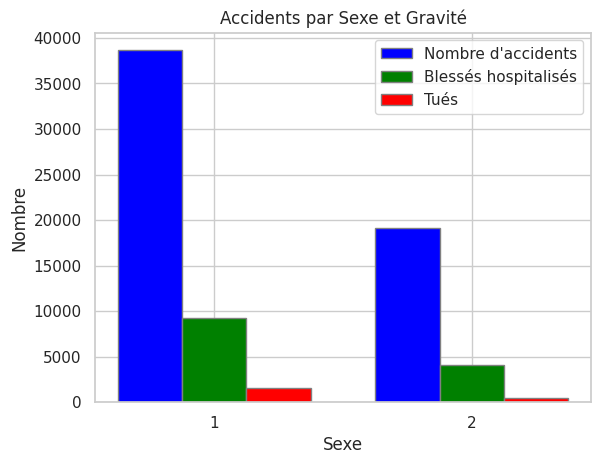

,sexe,somme_Nombre_Accident,somme_Tué,somme_Blessé_hospitalisé
0,1,38646,1606,9221
1,2,19137,466,4129


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def carte(df):
    """
    Cette fonction permet de tracer les accidents effectués par les hommes et femmes, ainsi que leur gravité.
    """
    df = df.filter(
        (F.col('Conditions_lumière') != 'Data missing or out of range') &
        (F.col('Atmosphere') != 'Data missing or out of range') &
        (F.col('Atmosphere') != 'Unknown') &
        (F.col('Conditions_Surface') != 'Data missing or out of range'))

    df = df.groupBy("sexe").agg(
        sum("Nombre_Accident").alias("somme_Nombre_Accident"),
        sum("Tué").alias("somme_Tué"),
        sum("Blessé hospitalisé").alias("somme_Blessé_hospitalisé"))

    df = df.toPandas()

    # Définir les positions des barres sur l'axe X
    n_sexe = len(df['sexe'])
    barWidth = 0.25
    r1 = np.arange(n_sexe)
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Créer les barres
    plt.bar(r1, df['somme_Nombre_Accident'], color='blue', width=barWidth, edgecolor='grey', label='Nombre d\'accidents')
    plt.bar(r2, df['somme_Blessé_hospitalisé'], color='green', width=barWidth, edgecolor='grey', label='Blessés hospitalisés')
    plt.bar(r3, df['somme_Tué'], color='red', width=barWidth, edgecolor='grey', label='Tués')

    # Ajouter des légendes et des titres
    plt.xlabel('Sexe')
    plt.ylabel('Nombre')
    plt.title('Accidents par Sexe et Gravité')
    plt.xticks([r + barWidth for r in range(n_sexe)], df['sexe'])

    plt.legend()

    # Afficher le graphique
    plt.show()

    return df


carte(Acc_df)

In [28]:
# @title
# Ce script calcule le nombre d'accidents par voiture

resultat2 = Acc_df.groupBy("Catégorie_vehicule").agg(
    sum("Nombre_Accident").alias("somme_Nombre_Accident"),
    sum("Tué").alias("somme_Tué"),
    sum("Blessé hospitalisé").alias("somme_Blessé_hospitalisé")
)



Le graphique met en évidence une forte proportion d'accidents en France impliquant des voitures seules(véhicule 7). Cette observation peut refléter diverses causes, telles que des erreurs de conduite, des conditions routières défavorables. Le fait qu'une seule voiture soit impliquée dans de nombreux accidents suggère des problèmes potentiels liés à la conduite individuelle et à la sécurité des véhicules.

 + Renforcer les programmes de formation des conducteurs, en mettant l'accent sur les techniques de conduite défensive.

 + Renforcer les lois sur la sécurité routière, en particulier concernant la vitesse excessive et la conduite sous influence.

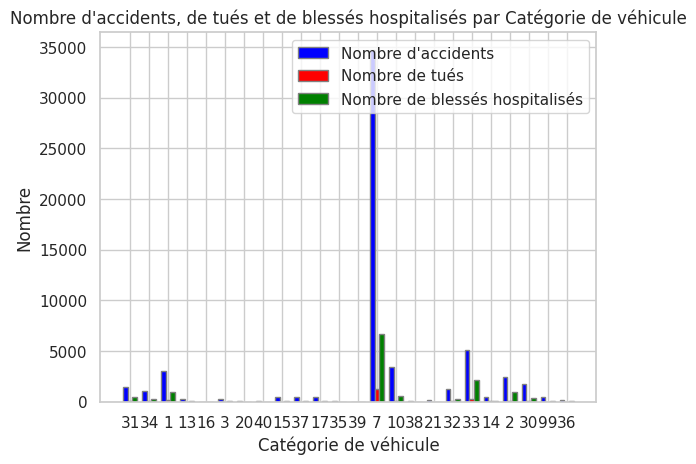

In [29]:

display(Markdown("""Le graphique met en évidence une forte proportion d'accidents en France impliquant des voitures seules(véhicule 7). Cette observation peut refléter diverses causes, telles que des erreurs de conduite, des conditions routières défavorables. Le fait qu'une seule voiture soit impliquée dans de nombreux accidents suggère des problèmes potentiels liés à la conduite individuelle et à la sécurité des véhicules.

 + Renforcer les programmes de formation des conducteurs, en mettant l'accent sur les techniques de conduite défensive.

 + Renforcer les lois sur la sécurité routière, en particulier concernant la vitesse excessive et la conduite sous influence."""))







import matplotlib.pyplot as plt
import numpy as np

def plot_accidents_by_vehicule_category(df):
    df = df.toPandas()
    df['Catégorie_vehicule'] = df['Catégorie_vehicule'].astype(str)

    # Définir les positions des barres sur l'axe X
    n_categories = len(df['Catégorie_vehicule'])
    barWidth = 0.25
    r1 = np.arange(n_categories)
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Créer les barres
    plt.bar(r1, df['somme_Nombre_Accident'], color='blue', width=barWidth, edgecolor='grey', label='Nombre d\'accidents')
    plt.bar(r2, df['somme_Tué'], color='red', width=barWidth, edgecolor='grey', label='Nombre de tués')
    plt.bar(r3, df['somme_Blessé_hospitalisé'], color='green', width=barWidth, edgecolor='grey', label='Nombre de blessés hospitalisés')

    # Ajouter des légendes et des titres
    plt.xlabel('Catégorie de véhicule')
    plt.ylabel('Nombre')
    plt.title('Nombre d\'accidents, de tués et de blessés hospitalisés par Catégorie de véhicule')
    plt.xticks([r + barWidth for r in range(n_categories)], df['Catégorie_vehicule'])

    plt.legend()

    # Afficher le graphique
    plt.show()

# Utiliser la fonction avec votre DataFrame
plot_accidents_by_vehicule_category(resultat2)



In [31]:
# @title
Acc = Acc_df.withColumn("AnnéeNessaince", 2018-col("AnnéeNessaince"))




In [32]:
# @title
# Ce script calcule le nombre d'accidents par voiture

Age = Acc.groupBy("AnnéeNessaince").agg(
    sum("Nombre_Accident").alias("somme_Nombre_Accident"),
    sum("Tué").alias("somme_Tué"),
    sum("Blessé hospitalisé").alias("somme_Blessé_hospitalisé")
)



Ce graphique illustre la fréquence des accidents de la route en fonction de l'âge des conducteurs. Il ressort que les individus âgés de 16 à 43 ans sont impliqués dans un nombre élevé d'accidents. Cette tendance peut être attribuée à divers facteurs, tels que l'expérience de conduite moins développée chez les jeunes conducteurs, ou un comportement de conduite potentiellement plus risqué dans cette tranche d'âge.

 + Mettre en place des programmes d'éducation à la conduite ciblés pour les jeunes conducteurs, en insistant sur les risques et les responsabilités liés à la conduite.
 + Organiser des campagnes de sensibilisation sur les dangers spécifiques pour les conducteurs dans cette tranche d'âge, comme la conduite sous influence ou la distraction au volant.

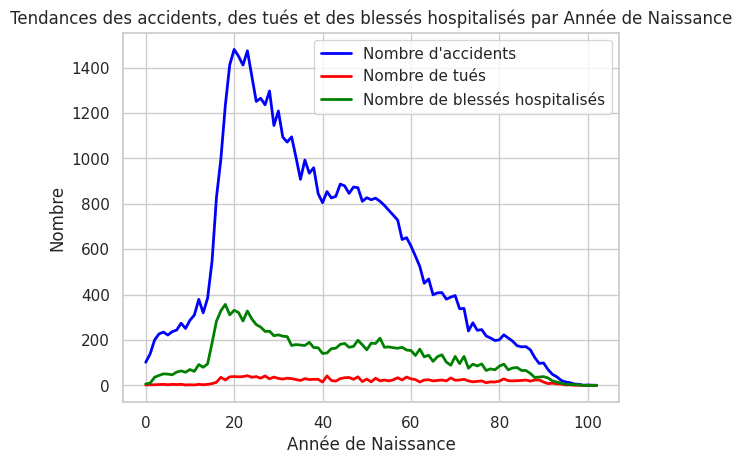

In [33]:
# @title
display(Markdown("""Ce graphique illustre la fréquence des accidents de la route en fonction de l'âge des conducteurs. Il ressort que les individus âgés de 16 à 43 ans sont impliqués dans un nombre élevé d'accidents. Cette tendance peut être attribuée à divers facteurs, tels que l'expérience de conduite moins développée chez les jeunes conducteurs, ou un comportement de conduite potentiellement plus risqué dans cette tranche d'âge.

 + Mettre en place des programmes d'éducation à la conduite ciblés pour les jeunes conducteurs, en insistant sur les risques et les responsabilités liés à la conduite.
 + Organiser des campagnes de sensibilisation sur les dangers spécifiques pour les conducteurs dans cette tranche d'âge, comme la conduite sous influence ou la distraction au volant."""))
import matplotlib.pyplot as plt

def plot_accidents_by_birth_year(df):
    df = df.toPandas().sort_values(by='AnnéeNessaince', ascending=True)

    # Créer des lignes pour chaque catégorie
    plt.plot(df['AnnéeNessaince'], df['somme_Nombre_Accident'], label='Nombre d\'accidents', color='blue', linewidth=2)
    plt.plot(df['AnnéeNessaince'], df['somme_Tué'], label='Nombre de tués', color='red', linewidth=2)
    plt.plot(df['AnnéeNessaince'], df['somme_Blessé_hospitalisé'], label='Nombre de blessés hospitalisés', color='green', linewidth=2)

    # Mise à jour de la mise en page
    plt.title('Tendances des accidents, des tués et des blessés hospitalisés par Année de Naissance')
    plt.xlabel('Année de Naissance')
    plt.ylabel('Nombre')
    plt.legend()

    # Afficher le graphique
    plt.show()

# Utiliser la fonction avec votre DataFrame
plot_accidents_by_birth_year(Age)



In [34]:
# @title
Acc_df7 = Acc_df.filter(Acc_df["Catégorie_vehicule"] == 7)

In [35]:
# @title


#ici c'est la selection des varibles
data=Acc_df7.select(col("Conditions_lumière"), col("Agglomération"),col("Atmosphere"),col("Catégorie_Route"), col("Conditions_Surface"),col("Gravité_accident"), col("sexe"))

# Machine learning


Dans cette étude, J'ai développé un modèle prédictif pour déterminer le sexe des individus impliqués dans des accidents de la route où ils étaient seuls, c'est-à-dire impliquant des véhicules de type 7. Pour ce faire, le modèle prend en compte plusieurs variables, notamment les conditions de luminosité, la présence ou non en agglomération, les conditions atmosphériques, la catégorie de la route, l'état de la surface de la route, ainsi que la gravité de l'accident.

In [ ]:
# @title
data = jointwithdatasets(caracteristiques, lieuxs, usagers, vehicules ).dropDuplicates(['Num_Acc'])
data= renameColumn(data)
data=data.select(col("Conditions_lumière"), col("Agglomération"),col("Atmosphere"),col("Catégorie_Route"), col("Conditions_Surface"),col("Gravité_accident"), col("sexe"))

In [ ]:
# @title
df_clean = data.na.drop()
df_clean = df_clean.withColumn('label', when(df_clean['sexe'] == 1, 1).otherwise(0))
df_clean = df_clean.drop('sexe')

In [ ]:
# @title
from pyspark.sql.functions import when

# Calculez le ratio des classes pour déterminer les poids
major_df = df_clean.filter(col("label") == 1)
minor_df = df_clean.filter(col("label") == 0)
ratio = major_df.count() / minor_df.count()

# Créez une nouvelle colonne 'weightCol' avec des poids différents pour chaque classe
df_clean = df_clean.withColumn("classWeights", when(df_clean["label"] == 0, ratio).otherwise(1))


In [ ]:
# @title
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator



numeric_columns = df_clean.columns
numeric_columns.remove('label')
numeric_columns.remove('classWeights')


assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")

df_assembled = assembler.transform(df_clean)

# 4. Division des données
train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=12345)
layers = [6, 50, 100, 50, 25, 10, 5, 2]



GBT = GBTClassifier(featuresCol="features", labelCol="label", weightCol="classWeights")


model = GBT.fit(train_data)

# 6. Prédiction sur l'ensemble de test
predictions = model.transform(test_data)

# 7. Évaluation du modèle
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)



AUC: 0.577126490529033


In [ ]:
# @title


from pyspark.sql.functions import col

tp = predictions.filter((col('prediction') == 1) & (col('label') == 1)).count()
tn = predictions.filter((col('prediction') == 0) & (col('label') == 0)).count()
fp = predictions.filter((col('prediction') == 1) & (col('label') == 0)).count()
fn = predictions.filter((col('prediction') == 0) & (col('label') == 1)).count()

confusion_matrix = [[tn, fp], [fn, tp]]



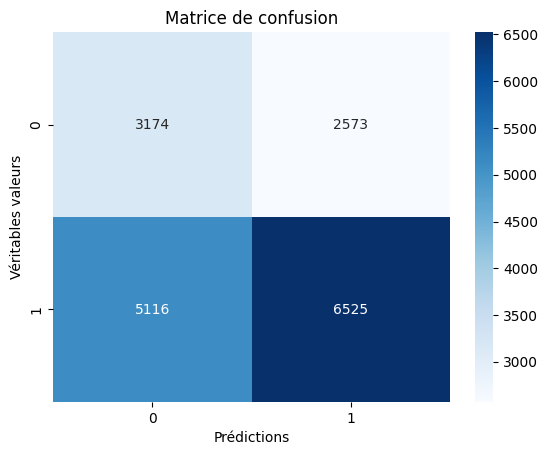

In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Véritables valeurs')
plt.title('Matrice de confusion')
plt.show()

In [ ]:
# @title
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(GBT.maxDepth, [2, 5, 10])
             .addGrid(GBT.maxBins, [20, 40, 80])
             .addGrid(GBT.maxIter, [10, 20, 50])
             .build())
crossval = CrossValidator(estimator=GBT,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # Number of folds for cross-validation

cvModel = crossval.fit(train_data)

predictions = cvModel.transform(test_data)


In [ ]:
# @title

auc = evaluator.evaluate(predictions)
print("AUC with Grid Search:", auc)



AUC with Grid Search: 0.5789269465981342


## Conclusion
En synthèse, l'analyse des données relatives aux accidents de la route en France met en évidence des tendances significatives liées aux heures de pointe, à la géographie, aux conditions météorologiques, et à l'âge des conducteurs. Pour améliorer la sécurité routière, des mesures ciblées telles que l'optimisation du trafic, le renforcement de l'entretien des routes, la sensibilisation des conducteurs, et l'application de lois plus strictes sur la vitesse et la conduite sous influence sont essentielles. Ces actions conjuguées peuvent contribuer à réduire le nombre d'accidents et à sauver des vies sur les routes.